In [2]:
import numpy as np

full_data = np.load('./data/full_data_feb15.npy', allow_pickle=True)
X_train_event, X_test_event, X_train_obj, X_test_obj, y_train, y_test = full_data

In [3]:
import tensorflow as tf
from tensorflow import keras

2022-02-22 20:27:35.829919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
# Build NN
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Flatten, AlphaDropout, LayerNormalization, GRU, Dropout
from tensorflow.keras.models import Model, Sequential
from keras.regularizers import l2

opt = keras.optimizers.RMSprop()


# RNN part
obj_input = Input(shape=X_train_obj.shape[1:])
# conv1 = keras.layers.Conv1D(filters=10, kernel_size=4, strides=2, padding="valid")(obj_input)
# gru1 = GRU(200, return_sequences=True, dropout=0.2)(conv1)
# ln1 = LayerNormalization()(gru1)
# gru1 = GRU(200, return_sequences=True)(obj_input)
# ln1 = LayerNormalization()(gru1)
# gru2 = GRU(200)(ln1)
# ln2 = LayerNormalization()(gru2)
# gru2 = GRU(100)(ln1)
# ln2 = LayerNormalization()(gru2)
# lstm_output = Dense(1, activation="sigmoid")(lstm1)
gru1 = GRU(14, return_sequences=True)(obj_input)
ln1 = LayerNormalization()(gru1)
gru2 = GRU(14)(ln1)
ln2 = LayerNormalization()(gru2)
event_input = Input(shape=X_train_event.shape[1])
x = Concatenate()([ln2, event_input])
# x = Concatenate()([ln2, event_input])
# Feedforward part
hidden1 = Dense(20, activation='selu', kernel_initializer='lecun_normal')(x)
do3 = AlphaDropout(rate=0.1)(x)
hidden2 = Dense(10, activation='selu', kernel_initializer='lecun_normal')(do3)
do4 = AlphaDropout(rate=0.1)(hidden2)
# hidden3 = Dense(200, activation='selu', kernel_initializer='lecun_normal')(do4)
# do5 = AlphaDropout(rate=0.2)(hidden3)
# hidden4 = Dense(200, activation="selu", kernel_initializer="lecun_normal")(do5)
# do4 = AlphaDropout(rate=0.75)(hidden4)
out = Dense(1, activation="sigmoid")(do4)
# event_output = Dense(1, activation='sigmoid')(hidden3)
# out_combined = Concatenate()([lstm_output, event_output])
# out = Dense(1, activation="sigmoid")(out_combined)
combined_model = Model(inputs=[obj_input, event_input], outputs=out)
combined_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.BinaryAccuracy()])
print(combined_model.summary())

2022-02-22 20:29:20.900754: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-22 20:29:20.902182: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-22 20:29:21.811338: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-22 20:29:21.813928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-22 20:29:21.816538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:5f:00.0 name: Tesla T4 computeCapability: 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 7)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 14, 14)       966         input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 14, 14)       28          gru[0][0]                        
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 14)           1260        layer_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
from keras.models import Sequential

conv_model = Sequential([
    keras.layers.Conv1D(filters=13, kernel_size=4, strides=2, padding="valid", input_shape=X_train_obj.shape[1:]),
    keras.layers.GRU(200, return_sequences=True),
    keras.layers.GRU(200),
    Dense(1, activation="sigmoid")
])
conv_model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=[keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.BinaryAccuracy()])
conv_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6, 13)             377       
_________________________________________________________________
gru_6 (GRU)                  (None, 6, 200)            129000    
_________________________________________________________________
gru_7 (GRU)                  (None, 200)               241200    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 370,778
Trainable params: 370,778
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Imbalanced dataset so want to adjusts weights of signal and background training examples
tot = len(y_train)
pos = np.sum(y_train['ttH125'])
neg = tot - pos
print(f'Total training samples:  {tot}\npositives:  {pos}\nnegatives:  {neg}')

# weight positives more than negatives
weight_for_0 = (1 / neg) * (tot / 2.0)
weight_for_1 = (1 / pos) * (tot / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f'Postive weight:  {weight_for_1} \nNegative weight:  {weight_for_0}')

Total training samples:  327177
positives:  79444
negatives:  247733
Postive weight:  2.0591674638739237 
Negative weight:  0.660341981084474


In [4]:
#oversample

y_train = y_train.values

pos = y_train[:,-1]==1

ids = np.where(pos)[0]
choices = np.random.choice(ids, len(y_train) - np.sum(pos))

pos_features_event, pos_features_obj = X_train_event[choices], X_train_obj[choices]
res_pos_labels = y_train[choices]
print(pos_features_event.shape, pos_features_obj.shape)

resampled_event = np.concatenate([X_train_event[~pos], pos_features_event], axis=0)
resampled_obj = np.concatenate([X_train_obj[~pos], pos_features_obj], axis=0)

neg_labels = y_train[~pos]
resampled_labels = np.concatenate([neg_labels, res_pos_labels,])
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_labels = resampled_labels[order]
resampled_event = resampled_event[order]
resampled_obj = resampled_obj[order]

print(resampled_obj.shape, resampled_event.shape)

(247733, 11) (247733, 14, 7)
(495466, 14, 7) (495466, 11)


In [5]:
y_train_resampled = resampled_labels[:,-1]

In [6]:
y_test = y_test.values

In [5]:
lr_scedueler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=1)
history = combined_model.fit([resampled_obj, resampled_event], y_train_resampled, epochs=40, 
            validation_data=([X_test_obj, X_test_event], y_test[:,-1]), batch_size=128)

NameError: name 'resampled_obj' is not defined

In [13]:
combined_model.save('./feb_14')

2022-02-14 18:58:30.585555: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./feb_14/assets


INFO:tensorflow:Assets written to: ./feb_14/assets


In [3]:
combined_model = keras.models.load_model('./feb_11')
combined_model.summary()

2022-02-15 16:09:06.766455: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-15 16:09:06.768104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-15 16:09:06.919850: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-15 16:09:06.921602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-15 16:09:06.923255: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:5f:00.0 name: Tesla T4 computeCapability: 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 14, 7)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 100)          43200       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
layer_normalization_2 (LayerNor (None, 100)          200         lstm_2[0][0]                     
____________________________________________________________________________________________

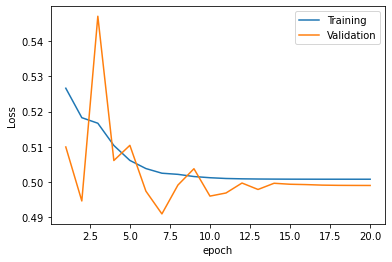

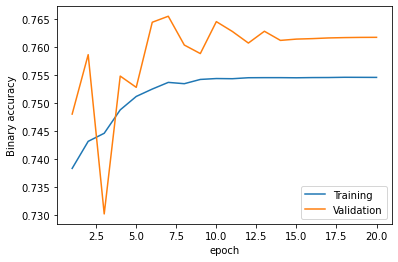

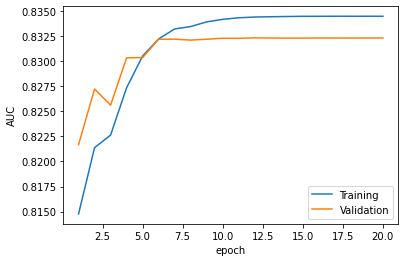

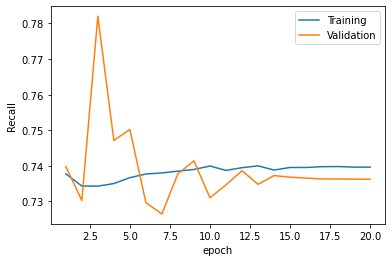

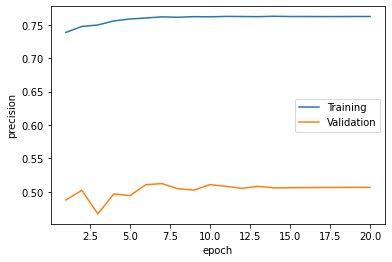

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1,21), history.history['loss'], label='Training')
plt.plot(range(1,21), history.history['val_loss'], label='Validation')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("./first_lstm_loss.png", dpi=200)
plt.show()

plt.plot(range(1, 21), history.history['binary_accuracy'], label='Training')
plt.plot(range(1, 21), history.history['val_binary_accuracy'], label='Validation')
plt.ylabel("Binary accuracy")
plt.xlabel("epoch")
plt.legend()
# plt.savefig("./first_lstm_accuracy.png", dpi=200)
plt.show()

plt.plot(range(1, 21), history.history['auc_2'], label='Training')
plt.plot(range(1, 21), history.history['val_auc_2'], label='Validation')
plt.ylabel("AUC")
plt.xlabel("epoch")
plt.legend()
# plt.savefig("./first_lstm_AUC.png", dpi=200)
plt.show()

plt.plot(range(1, 21), history.history['recall_2'], label='Training')
plt.plot(range(1, 21), history.history['val_recall_2'], label='Validation')
plt.ylabel('Recall')
plt.xlabel("epoch")
plt.legend()
# plt.savefig("./first_lstm_recall.png", dpi=200)
plt.show()

plt.plot(range(1, 21), history.history['precision_2'], label='Training')
plt.plot(range(1, 21), history.history['val_precision_2'], label='Validation')
plt.ylabel("precision")
plt.xlabel("epoch")
plt.legend()
# plt.savefig("./first_lstm_precision.png", dpi=200)
plt.show()

In [4]:
#Model predictions
with keras.backend.learning_phase_scope(1): 
    y_probas = np.stack([combined_model.predict([X_test_obj, X_test_event]) for sample in range(100)]) 
    y_pred = y_probas.mean(axis=0)

# y_pred = combined_model.predict([X_test_obj, X_test_event])
# y_train_pred = combined_model.predict([X_train_obj, X_train_event])


/software/ac18804/miniconda3/envs/gpu_env/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:492: UserWarning: `tf.keras.backend.learning_phase_scope` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.learning_phase_scope` is deprecated and '
2022-02-15 16:09:49.881549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-15 16:09:49.882080: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-02-15 16:09:50.264180: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-15 16:09:50.620889: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-02-15 16:09:51.163655: E

UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[model_2/lstm_2/PartitionedCall]] [Op:__inference_predict_function_8996]

Function call stack:
predict_function -> predict_function -> predict_function


In [ ]:
np.save("./y_pred_feb_11.npy", y_pred)

In [54]:
y_pred = np.load("./y_pred_feb_11.npy")
y_pred

array([[0.5485497 ],
       [0.23549275],
       [0.30994406],
       ...,
       [0.09543934],
       [0.68062174],
       [0.00749332]], dtype=float32)

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(resampled_event, y_train_resampled)
lr_predictions = lr.predict_proba(X_test_event)[:,1]

In [11]:
y_pred = combined_model.predict([X_test_obj, X_test_event])
y_pred = y_pred.reshape(y_pred.shape[0])

2022-02-15 10:01:37.784126: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-15 10:01:37.784855: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2022-02-15 10:01:38.324700: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-15 10:01:38.630542: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [16]:
# Analysis

thresholds = np.arange(0, 1.001, 0.001)
FP = np.zeros(len(thresholds))
FN = np.zeros(len(thresholds))
TP = np.zeros(len(thresholds))
TN = np.zeros(len(thresholds))
lr_FP = np.zeros(len(thresholds))
lr_TP = np.zeros(len(thresholds))

test = y_test[:,-1]
y_pred = y_pred.reshape(len(test))

for idx, threshold in enumerate(thresholds):
    # FP[idx] = ((y_test[y_test['ttH125'] == 0]) & (y_pred >= threshold)).sum()
    # FN[idx] = ((y_test[y_test['ttH125'] == 1]) & (y_pred < threshold)).sum()
    # TP[idx] = ((y_test[y_test['ttH125'] == 1]) & (y_pred >= threshold)).sum()
    # TN[idx] = ((y_test[y_test['ttH125'] == 0]) & (y_pred < threshold)).sum()
    # FP[idx] = len(y_test[(y_test['ttH125']==0) & (y_test['Predictions'] >= threshold)])
    # FN[idx] = len(y_test[(y_test['ttH125']==1) & (y_test['Predictions'] < threshold)])
    # TP[idx] = len(y_test[(y_test['ttH125']==1) & (y_test['Predictions'] >= threshold)])
    # TN[idx] = len(y_test[(y_test['ttH125']==0) & (y_test['Predictions'] < threshold)])
    FP[idx] = ((y_pred >= threshold) & (test==0)).sum()
    FN[idx] = ((y_pred < threshold) & (test==1)).sum()
    TP[idx] = ((y_pred >= threshold) & (test==1)).sum()
    TN[idx] = ((y_pred < threshold) & (test==0)).sum()

    lr_FP[idx] = ((lr_predictions >= threshold) & (test==0)).sum()
    lr_TP[idx] = ((lr_predictions >= threshold) & (test==1)).sum()


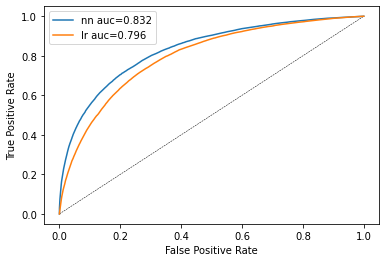

In [17]:
import matplotlib.pyplot as plt

# ROC curve
tpr = TP/(np.sum(test))
fpr = FP/(len(test) - np.sum(test))
tpr_lr = lr_TP/np.sum(test)
fpr_lr = lr_FP/(len(test)-np.sum(test))
plt.plot(fpr, tpr, label='nn auc=0.832')
plt.plot(np.arange(0, 1.0001, 0.0001), np.arange(0, 1.0001, 0.0001), linestyle='dashed', linewidth=0.5, color='k')
plt.plot(fpr_lr,tpr_lr, label='lr auc=0.796')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
# plt.savefig("./first_lstm_vs_lr_ROC.png", dpi=200)
plt.show()

In [18]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test, y_pred)
auc

0.8315951793046408

In [22]:
f1 = TP/(TP+0.5*(FP+FN))
thresholds[np.argmax(f1)]

0.595

In [24]:
np.argmax(f1)

595

In [23]:
# Significance

# load xs weights
train_weights, test_weights = np.load('weights.npy', allow_pickle=True)

# Get predictions for combined dataset
# y_pred_train = combined_model.predict([X_train_obj, X_train_event])
# y_total = np.concatenate([y_train, y_test])
# y_pred_train = y_pred_train.reshape(y_train.shape)
# y_pred_total = np.concatenate([y_pred_train, y_pred])

In [21]:
total_weights = np.concatenate([train_weights, test_weights])

In [8]:
significance = np.zeros(len(thresholds), dtype=float)
lum = 140e3
sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
sigma = 0.05

for idx, threshold in enumerate(thresholds):
    sg[idx] = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 1)).astype(int)).sum()
    bg[idx] = (lum * total_weights * ((y_pred_total >= threshold) & (y_total == 0)).astype(int)).sum()
    if bg[idx] > 0:
        significance[idx] = sg[idx]/np.sqrt(bg[idx] + (sigma * bg[idx])**2)
    else:
        end_idx = idx
    # print(f"Signal events surviving cut:  {sg[idx]}\nBackground events surviving cut:  {bg[idx]}\nCorresponding siginificance is:  {significance[idx]}")

NameError: name 'total_weights' is not defined

In [25]:
significance_sigma0 = np.zeros(len(thresholds))
significance_sigma5 = np.zeros(len(thresholds))
significance_sigma10 = np.zeros(len(thresholds))

lum = 140e3
sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
sigma = 0.1

for idx, threshold in enumerate(thresholds):
    sg[idx] = (lum * test_weights * 5 * ((y_pred >= threshold) & (test == 1)).astype(int)).sum()
    bg[idx] = (lum * test_weights * 5 * ((y_pred >= threshold) & (test == 0)).astype(int)).sum()
    if bg[idx] > 0:
        significance_sigma0[idx] = sg[idx]/np.sqrt(bg[idx])
        significance_sigma5[idx] = sg[idx]/np.sqrt(bg[idx] + (0.05 * bg[idx])**2)
        significance_sigma10[idx] = sg[idx]/np.sqrt(bg[idx] + (0.1 * bg[idx])**2)
    
    # print(f"Signal events surviving cut:  {sg[idx]}\nBackground events surviving cut:  {bg[idx]}\nCorresponding siginificance is:  {significance[idx]}")

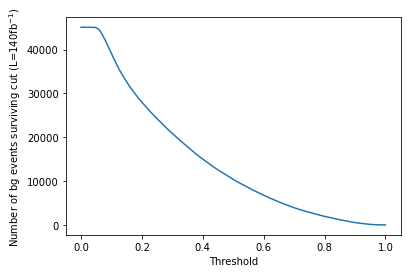

In [26]:
import matplotlib.pyplot as plt

plt.plot(thresholds, bg)
# plt.plot(thresholds, np.sqrt(bg), label="sqrt backgrounds")
plt.xlabel("Threshold")
plt.ylabel(r"Number of bg events surviving cut (L=140fb$^{-1}$)")
# plt.savefig("./first_lstm_bg_surviving.png", dpi=200)
plt.show()

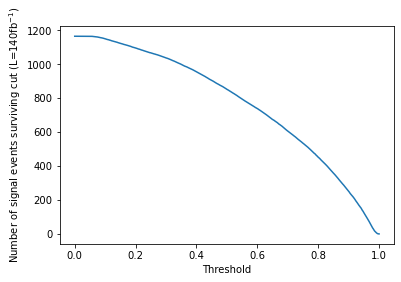

In [27]:
plt.plot(thresholds, sg)
plt.xlabel("Threshold")
plt.ylabel(r"Number of signal events surviving cut (L=140fb$^{-1}$)")
# plt.savefig("./first_lstm_sg_surviving.png", dpi=200)
plt.show()

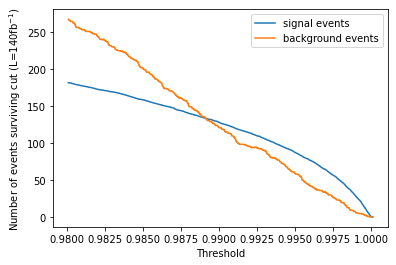

In [20]:
plt.plot(thresholds[-2000:], sg[-2000:], label="signal events")
plt.plot(thresholds[-2000:], bg[-2000:], label="background events")
plt.xlabel("Threshold")
plt.ylabel(r"Number of events surviving cut (L=140fb$^{-1}$)")
plt.legend()
plt.show()

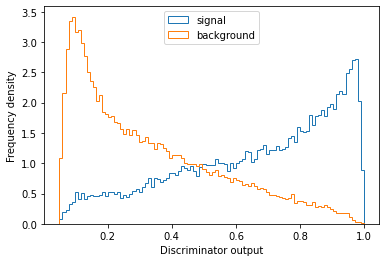

In [31]:
hist, bins, patches = plt.hist(y_pred[test==1], weights=lum*test_weights[test==1], bins=100, density=True, histtype='step', label="signal")
hist_, bins, patches = plt.hist(y_pred[test==0], weights=lum*test_weights[test==0], bins=bins, density=True, histtype='step', label="background")
plt.xlabel("Discriminator output")
plt.ylabel("Frequency density")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist, linewidth=1.2, label="signal")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist_, linewidth=1.2, label="background")
plt.legend(loc="upper center")
# plt.savefig("./first_lstm_Discriminator_test_set.png", dpi=200)
plt.show()

In [8]:
y_pred_train = combined_model.predict([X_train_obj, X_train_event])
y_pred_train = y_pred_train.reshape(y_pred_train.shape[0])
y_pred_train

array([0.23978144, 0.04599853, 0.16814369, ..., 0.98828167, 0.11218998,
       0.7608745 ], dtype=float32)

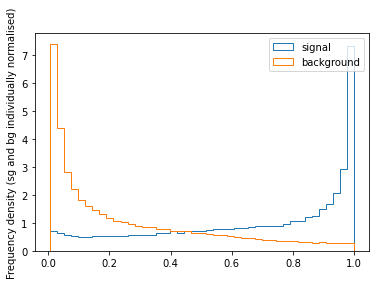

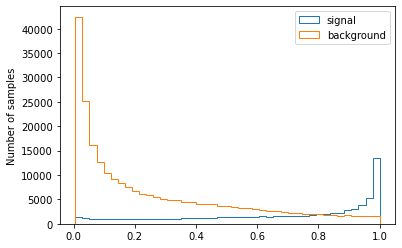

In [9]:
import matplotlib.pyplot as plt

hist_sg, bins, patches = plt.hist(y_pred_train[y_train.values[:,-1]==1], histtype='step', label="signal", density=True, bins='auto')
hist_bg, bins, patches = plt.hist(y_pred_train[y_train.values[:,-1]==0], histtype='step', label="background", density=True, bins=bins)
plt.ylabel("Frequency density (sg and bg individually normalised)")
plt.legend()
plt.show()

hist_sg_counts, bins_counts, patches = plt.hist(y_pred_train[y_train.values[:,-1]==1], histtype='step', label="signal", bins='auto')
hist_bg_counts, bins_counts, patches = plt.hist(y_pred_train[y_train.values[:,-1]==0], histtype='step', label="background", bins=bins_counts)
plt.ylabel("Number of samples")
plt.legend()
plt.show()


In [10]:
thresh = 0.8
labels = y_train.values[:,-1]
# y_pred_train = y_pred_train.reshape(labels.shape)
tp = (labels==1) & (y_pred_train >= thresh)
fp = (labels==0) & (y_pred_train >= thresh)



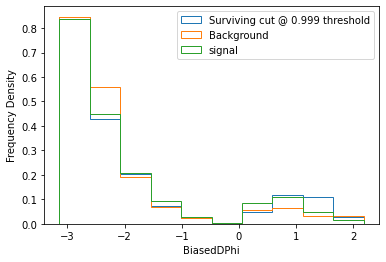

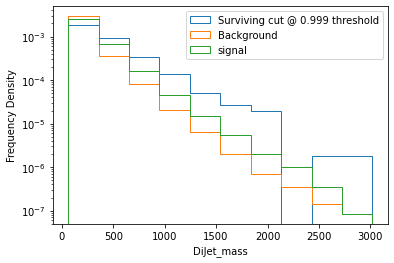

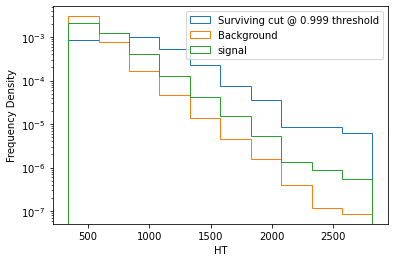

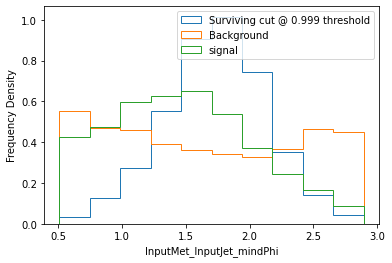

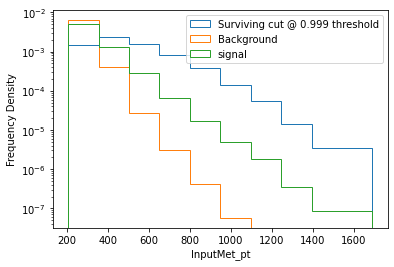

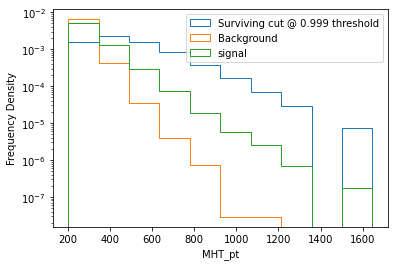

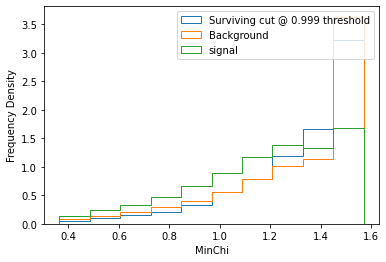

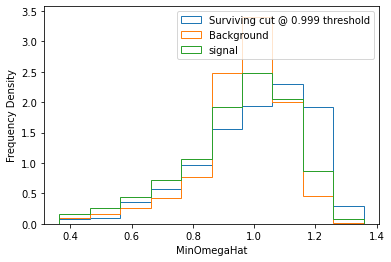

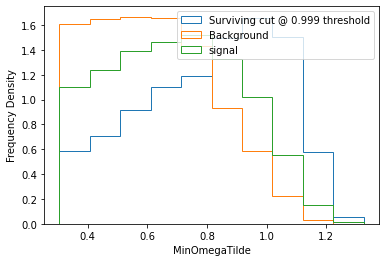

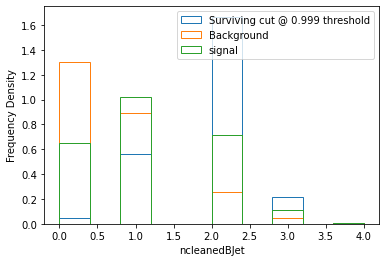

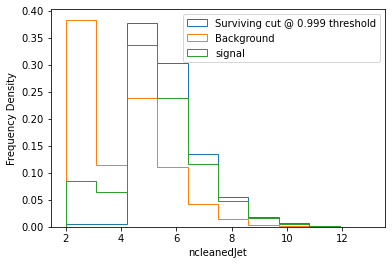

In [21]:
import pandas as pd

X_train_df = pd.read_hdf("./X_train_combined.hd5")
X_train_df_event = X_train_df.select_dtypes(exclude=object)
X_train_df_event = X_train_df_event.values

columns = ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'ncleanedBJet', 'ncleanedJet']

thresh = 0.999
for idx, column in enumerate(columns):
    if column in ['DiJet_mass', 'HT', 'InputMet_pt', 'MHT_pt']:
        log = True
    else:
        log = False
    if column == 'ncleanedBJet':
        bins = range(5)
    elif column == 'ncleanedJet':
        bins = range(2, 15)
    else:
        bins = 10
    # hist, bins, patches = plt.hist(X_train_df_event[:,idx][tp], log=log, bins=bins, label="True positives", histtype="step")
    # hist_, bins, patches = plt.hist(X_train_df_event[:,idx][fp], log=log, bins=bins, label="False positives", histtype="step")
    hist, bins, patches = plt.hist(X_train_df_event[:,idx][y_pred_train >= thresh], log=log, label=f"Surviving cut @ {thresh} threshold", histtype="step", density=True)
    plt.hist(X_train_df_event[:,idx][labels==0], log=log, bins=bins, label="Background", histtype="step", density=True)
    plt.hist(X_train_df_event[:,idx][labels==1], log=log, bins=bins, label="signal", histtype="step", density=True)
    # plt.hist(X_train_df_event[:,idx][tp], log=log, bins=bins, label="True positives", histtype="step", density=True)
    # plt.hist(X_train_df_event[:,idx][fp], log=log, bins=bins, label="False positives", histtype="step", density=True)
    plt.xlabel(column)
    plt.ylabel("Frequency Density")
    plt.legend()
    plt.show()    

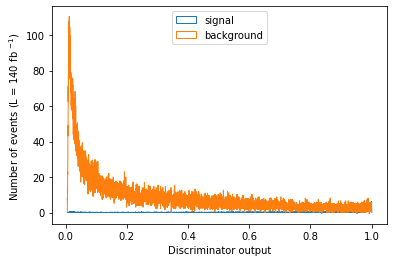

In [74]:
import matplotlib.pyplot as plt

lum = 140e3

hist, bins, patches = plt.hist(y_pred[test==1], weights=5*lum*test_weights[test==1], bins=5000, histtype='step', label="signal")
hist_, bins, patches = plt.hist(y_pred[test==0], weights=5*lum*test_weights[test==0], bins=bins, histtype='step', label="background")
plt.xlabel("Discriminator output")
plt.ylabel(r"Number of events (L = 140 fb $^{-1}$) ")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist, linewidth=1.2, label="signal")
# plt.plot(0.5 * (bins[:-1] + bins[1:]), hist_, linewidth=1.2, label="background")
plt.legend(loc="upper center")
# plt.savefig("./first_lstm_Discriminator_test_set_xs.png", dpi=200)
plt.show()

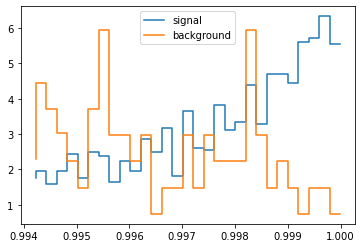

In [75]:
plt.step(bins[-30:], hist[-30:], label="signal")
plt.step(bins[-30:], hist_[-30:], label="background")
plt.legend()
plt.show()

<BarContainer object of 3 artists>

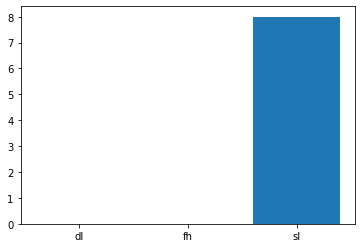

In [24]:
thresh = 0.999
plt.bar(['dl', 'fh', 'sl'], [np.sum(y_test[y_pred >= thresh][:,i]) for i in range(3)])

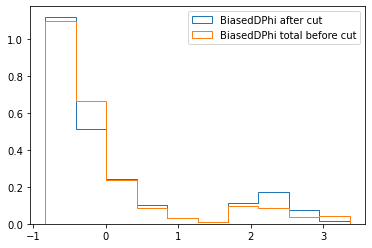

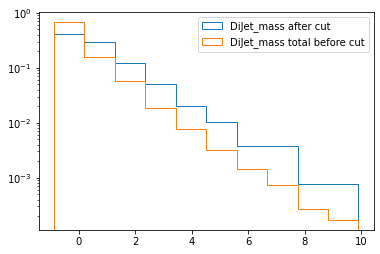

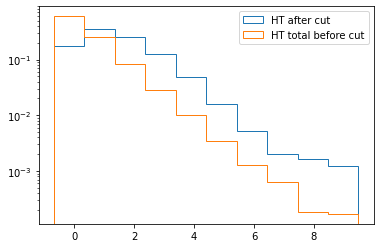

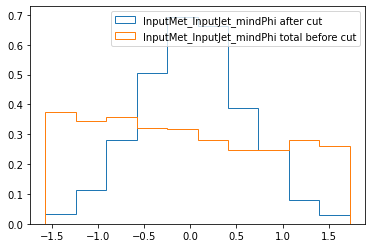

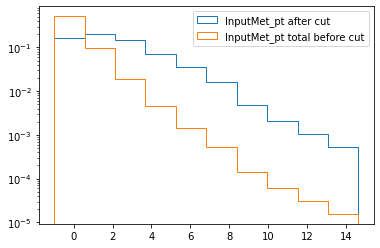

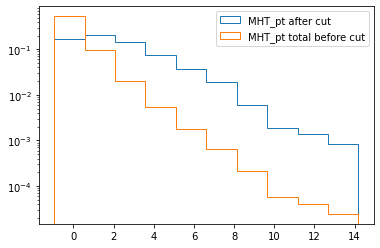

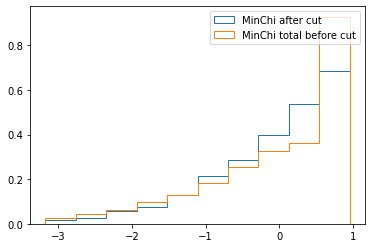

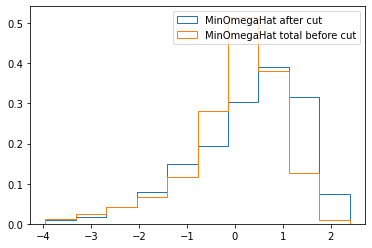

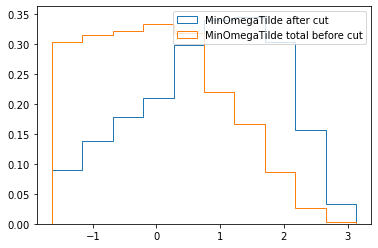

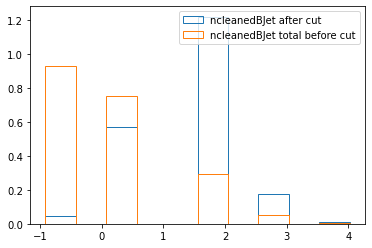

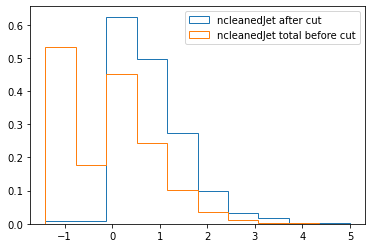

In [106]:
columns = ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'ncleanedBJet', 'ncleanedJet']
for idx, column in enumerate(columns):
    if column in ('HT', 'InputMet_pt', 'MHT_pt', 'DiJet_mass'):
        log = True
    else:
        log = False
    hist, bins, patches = plt.hist(X_test_event[y_pred >= thresh][:, idx], label=f'{column} after cut', log=log, density=True, histtype="step")
    plt.hist(X_test_event[:, idx], label=f'{column} total before cut', log=log, density=True, histtype="step", bins=bins)
    plt.legend()
    plt.show()

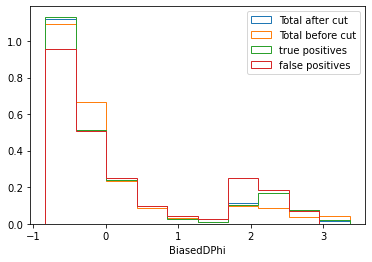

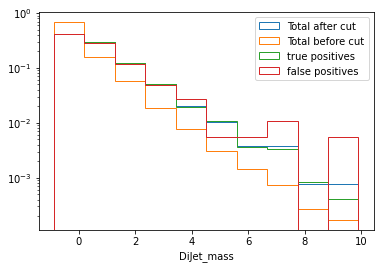

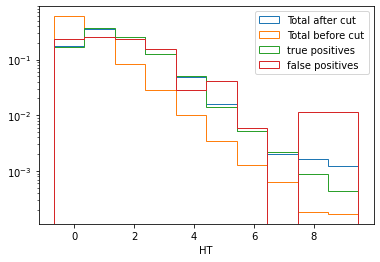

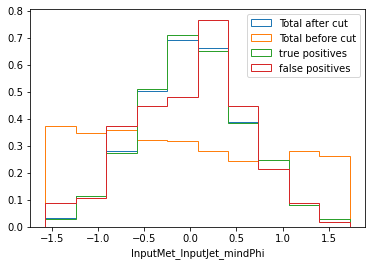

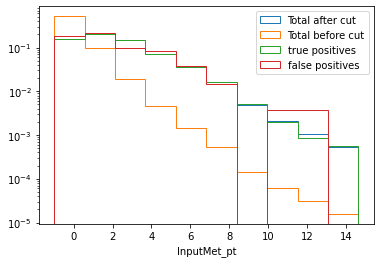

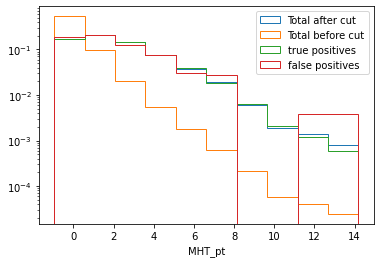

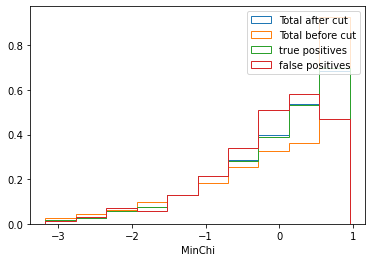

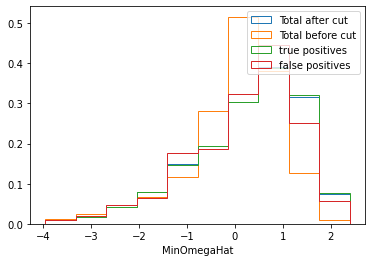

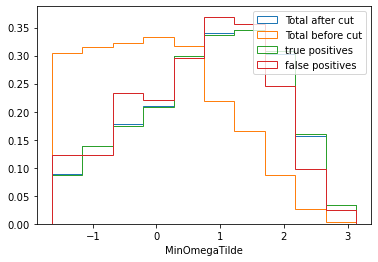

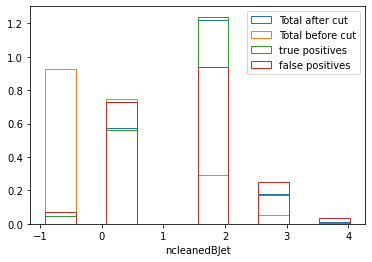

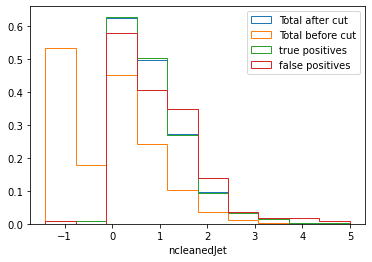

In [113]:
for idx, column in enumerate(columns):
    if column in ('HT', 'InputMet_pt', 'MHT_pt', 'DiJet_mass'):
        log = True
    else:
        log = False
    hist, bins, patches = plt.hist(X_test_event[y_pred >= thresh][:, idx], label=f'Total after cut', log=log, density=True, histtype="step")
    plt.hist(X_test_event[:, idx], label=f'Total before cut', log=log, density=True, histtype="step", bins=bins)
    plt.hist(X_test_event[(y_pred >= thresh) & (test==1)][:, idx], label=f"true positives", log=log, density=True, histtype="step", bins=bins)
    plt.hist(X_test_event[(y_pred >= thresh) & (test==0)][:, idx], label=f"false positives", log=log, density=True, histtype="step", bins=bins)
    plt.xlabel(column)
    plt.legend()
    plt.show()

In [1]:
import pandas as pd

X_test_df = pd.read_hdf("./X_test_combined.hd5")

In [25]:
X_test_df_event = X_test_df.select_dtypes(exclude=object)
X_test_df_event = X_test_df_event.values

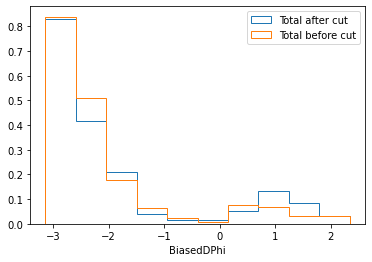

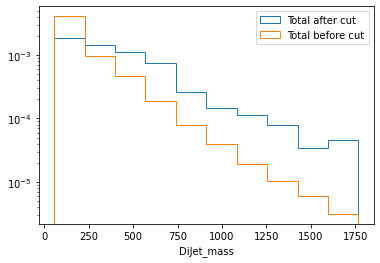

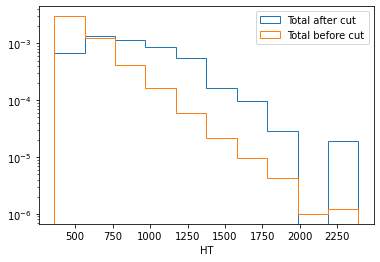

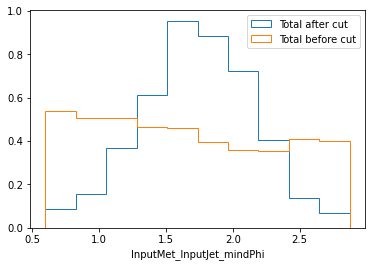

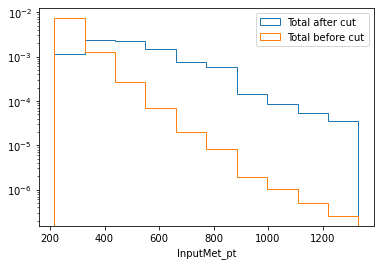

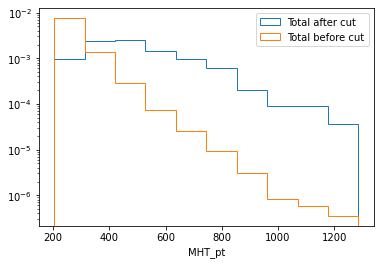

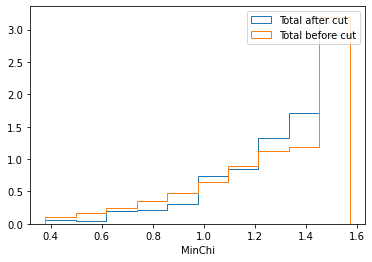

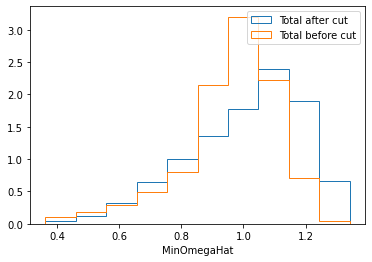

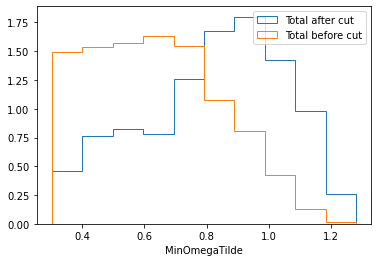

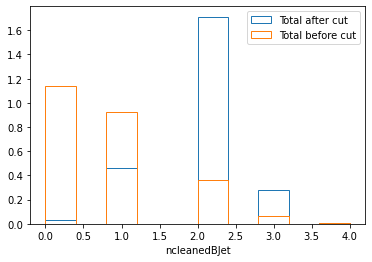

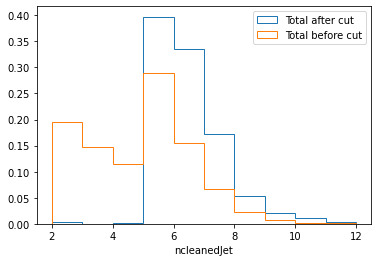

In [27]:
columns = ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'ncleanedBJet', 'ncleanedJet']

for idx, column in enumerate(columns):
       if column in ('HT', 'InputMet_pt', 'MHT_pt', 'DiJet_mass'):
              log = True
       else:
              log = False
       hist, bins, patches = plt.hist(X_test_df_event[y_pred >= thresh][:, idx], label=f'Total after cut', log=log, density=True, histtype="step")
       plt.hist(X_test_df_event[:, idx], label=f'Total before cut', log=log, density=True, histtype="step", bins=bins)
       # plt.hist(X_test_df_event[(y_pred >= thresh) & (test==1)][:, idx], label=f"true positives", log=log, density=True, histtype="step", bins=bins)
       # plt.hist(X_test_df_event[(y_pred >= thresh) & (test==0)][:, idx], label=f"false positives", log=log, density=True, histtype="step", bins=bins)
       plt.xlabel(column)
       plt.legend()
       plt.show()
       

In [31]:
print(f"Events in last bin: Signal = {hist[-1]},  background = {hist_[-1]}")

Events in last bin: Signal = 77.61056518554688,  background = 58.578125


In [35]:
print(np.sum(hist[-2:]), np.sum(hist_[-2:]))

114.49840927124023 115.1640625


In [44]:
idx = np.argmin(abs(tpr - 0.79))
significance_sigma0[idx]

7.964649271877132

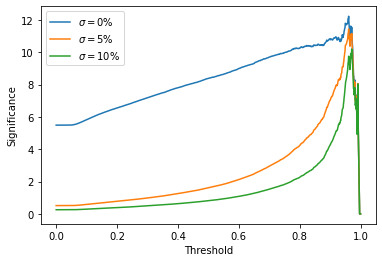

In [32]:
import matplotlib.pyplot as plt

plt.plot(thresholds, significance_sigma0, label=r"$\sigma=0\%$")
plt.plot(thresholds, significance_sigma5, label=r"$\sigma=5\%$")
plt.plot(thresholds, significance_sigma10, label=r"$\sigma=10\%$")
# plt.vlines(thresholds[np.argmax(significance)], linestyles="dashed", color='k', ymin=0, ymax=np.max(significance), linewidth=0.8,
#     label=f"Best threshold = {round(thresholds[np.argmax(significance[:end_idx])], 2)}")
# plt.hlines(np.max(significance), linestyles="dashed", color="k", xmin=0, xmax=1.0, linewidth=0.8)
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()

# plt.savefig("./first_lstm_significance_different_sigmas.png", dpi=200)
plt.legend()
plt.show()

In [33]:
idx_sig5 = np.argmin(abs(significance_sigma10-5))
thresholds[idx_sig5]

0.918

Best threshold for sigma=0% is 0.961 
Best threshold for sigma=5% is 0.961 
Best threshold for sigma=10% is 0.971


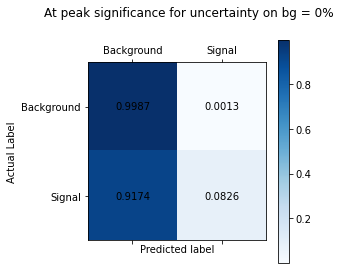

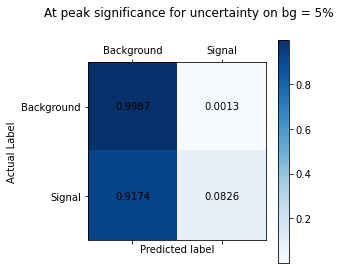

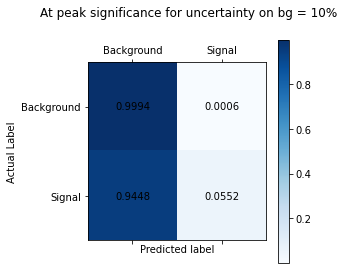

In [45]:
idx_0, idx_5, idx_10 = np.argmax(significance_sigma0), np.argmax(significance_sigma5), np.argmax(significance_sigma10)
print(f"Best threshold for sigma=0% is {thresholds[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}")
label = {0: 0, 1: 5, 2:10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap='Blues')
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel('Predicted label')
    plt.ylabel('Actual Label')
    plt.xticks([0,1], labels=['Background', 'Signal'])
    plt.yticks([0,1], labels=['Background', 'Signal'])
    plt.colorbar()
    plt.suptitle(f"At peak significance for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}.png", dpi=200)
    plt.show()

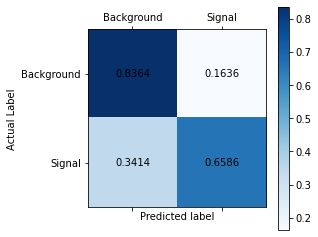

In [26]:
conf_mat = [[1-fpr[595], fpr[595]], [1-tpr[595], tpr[595]]]
plt.matshow(conf_mat, cmap='Blues')
for (x, y), value in np.ndenumerate(conf_mat):
    plt.text(y, x, f"{value:.4f}", va="center", ha="center")
plt.xlabel('Predicted label')
plt.ylabel('Actual Label')
plt.xticks([0,1], labels=['Background', 'Signal'])
plt.yticks([0,1], labels=['Background', 'Signal'])
plt.colorbar()
# plt.suptitle(f"At peak significance for uncertainty on bg = {label[j]}%")
# plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}.png", dpi=200)
plt.show()

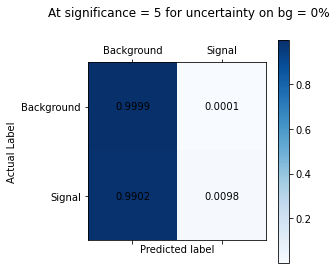

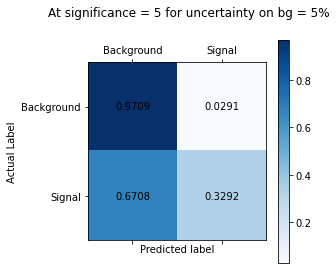

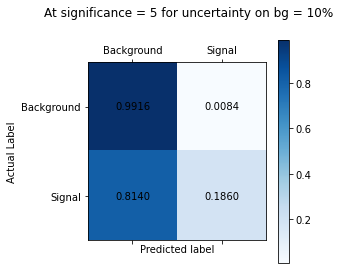

In [46]:
idx_0, idx_5, idx_10 = np.argmin(abs(5-significance_sigma0)), np.argmin(abs(5-significance_sigma5[:idx_5])), np.argmin(abs(5-significance_sigma10[:idx_10]))
# print(f"Best threshold for sigma=0% is {thresholds[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}")
label = {0: 0, 1: 5, 2:10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap='Blues')
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel('Predicted label')
    plt.ylabel('Actual Label')
    plt.xticks([0,1], labels=['Background', 'Signal'])
    plt.yticks([0,1], labels=['Background', 'Signal'])
    plt.colorbar()
    plt.suptitle(f"At significance = 5 for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}_sig_5.png", dpi=200)
    plt.show()